In [1]:
import sys
sys.path.append("..")
from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%run 1_preprocessing_data.ipynb

In [3]:
(
    data,
    filter_data, 
    train_data,
    test_data,
    y_train_boxcox,
    y_test_boxcox,
    boxcox_transformation_info,
) = run_preprocessing(ARIMA_model=False)


In [4]:
print(train_data.dtypes)

date            datetime64[ns]
volume.sales           float64
unit.sales               int64
value.sales            float64
supermarket             object
variant                 object
pack.size               object
brand                   object
price                  float64
dtype: object


ARIMAX

Realizamos un modelo ARIMA + exógenas global

1. Modelo de regresión para sacar las variables exógenas junto a sus coeficientes

In [5]:
model, selected_var, deleted_var = sa.regression_with_backward_elimination(train_data, verbose=True)
print(model.summary())


Fórmula del modelo:
volume_sales ~ price + C(supermarket) + C(variant) + C(pack_size) + C(brand) + (price + C(brand)) ** 2
Iteración 1: Eliminando 'C(pack_size)[T.450 - 600GR]' (p-valor = 0.8764)
Iteración 2: Eliminando 'price' (p-valor = 0.5457)
Iteración 3: Eliminando 'C(supermarket)[T.supermarket-C]' (p-valor = 0.0649)
Iteración 4: Eliminando 'price:C(brand)[T.brand-15]' (p-valor = 0.0688)
Iteración 5: Todas las variables restantes son significativas (p-valor ≤ 0.05)

Resumen:
  Variables iniciales: 18
  Variables seleccionadas: 14
  Variables eliminadas: 4
  R² ajustado: 0.3850
                            OLS Regression Results                            
Dep. Variable:           volume_sales   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     167.6
Date:                Wed, 28 Jan 2026   Prob (F-statistic):               0.00
Time:           

In [6]:
# ==========================================
# Función para crear variables dummy de intervención
# ==========================================

def add_intervention_dummy(
    train_data,
    x_train_exogs,
    intervention_date,
    dummy_name,
    brand=None,
    supermarkets=None,
    variants=None,
    pack_sizes=None,
    test_data=None,
    verbose=True
):
    """
    Crea y añade una variable dummy de intervención a x_train_exogs.
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        DataFrame de entrenamiento con columnas: date, brand, supermarket, variant, pack.size
    x_train_exogs : pd.DataFrame
        DataFrame de variables exógenas al que se añadirá la dummy
    intervention_date : str or pd.Timestamp
        Fecha de intervención (formato 'YYYY-MM-DD' o Timestamp)
    dummy_name : str
        Nombre de la variable dummy (ej: 'intervention_2023_03')
    brand : str or list, optional
        Marca(s) a filtrar. Si None, no filtra por brand
    supermarkets : str or list, optional
        Supermercado(s) a filtrar. Si None, no filtra por supermarket
    variants : str or list, optional
        Variante(s) a filtrar. Si None, no filtra por variant
    pack_sizes : str or list, optional
        Tamaño(s) de pack a filtrar. Si None, no filtra por pack.size
    test_data : pd.DataFrame, optional
        DataFrame de test para crear también la dummy en test
    verbose : bool, default=True
        Si True, imprime información sobre la dummy creada
    
    Returns:
    --------
    x_train_exogs : pd.DataFrame
        DataFrame de variables exógenas con la dummy añadida
    intervention_dummy_series : pd.Series
        Serie con la dummy para train_data
    intervention_dummy_test_series : pd.Series or None
        Serie con la dummy para test_data (si se proporcionó test_data)
    """
    # Convertir fecha a datetime
    if isinstance(intervention_date, str):
        intervention_date = pd.to_datetime(intervention_date)
    
    # Asegurar que train_data['date'] es datetime
    train_data = train_data.copy()
    train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Crear condiciones de filtrado
    conditions = train_data['date'] >= intervention_date
    
    if brand is not None:
        if isinstance(brand, str):
            conditions = conditions & (train_data['brand'] == brand)
        else:
            conditions = conditions & (train_data['brand'].isin(brand))
    
    if supermarkets is not None:
        if isinstance(supermarkets, str):
            conditions = conditions & (train_data['supermarket'] == supermarkets)
        else:
            conditions = conditions & (train_data['supermarket'].isin(supermarkets))
    
    if variants is not None:
        if isinstance(variants, str):
            conditions = conditions & (train_data['variant'] == variants)
        else:
            conditions = conditions & (train_data['variant'].isin(variants))
    
    if pack_sizes is not None:
        if isinstance(pack_sizes, str):
            conditions = conditions & (train_data['pack.size'] == pack_sizes)
        else:
            conditions = conditions & (train_data['pack.size'].isin(pack_sizes))
    
    # Crear la dummy para train_data
    intervention_dummy = conditions.astype(int)
    intervention_dummy_series = pd.Series(
        intervention_dummy.values,
        index=train_data.index,
        name=dummy_name
    )
    
    # Alinear con x_train_exogs
    intervention_dummy_aligned = intervention_dummy_series.reindex(x_train_exogs.index, fill_value=0)
    
    # Añadir a x_train_exogs
    x_train_exogs = pd.concat([x_train_exogs, intervention_dummy_aligned], axis=1)
    
    if verbose:
        print(f"\n✅ Dummy '{dummy_name}' añadida")
        print(f"   - Número de 1s: {intervention_dummy_aligned.sum()}")
        print(f"   - Porcentaje de 1s: {intervention_dummy_aligned.mean()*100:.2f}%")
        print(f"   - Shape actualizado de X_train_exogs: {x_train_exogs.shape}")
    
    # Crear también para test_data si se proporciona
    intervention_dummy_test_series = None
    if test_data is not None:
        test_data = test_data.copy()
        test_data['date'] = pd.to_datetime(test_data['date'])
        
        # Crear condiciones para test
        conditions_test = test_data['date'] >= intervention_date
        
        if brand is not None:
            if isinstance(brand, str):
                conditions_test = conditions_test & (test_data['brand'] == brand)
            else:
                conditions_test = conditions_test & (test_data['brand'].isin(brand))
        
        if supermarkets is not None:
            if isinstance(supermarkets, str):
                conditions_test = conditions_test & (test_data['supermarket'] == supermarkets)
            else:
                conditions_test = conditions_test & (test_data['supermarket'].isin(supermarkets))
        
        if variants is not None:
            if isinstance(variants, str):
                conditions_test = conditions_test & (test_data['variant'] == variants)
            else:
                conditions_test = conditions_test & (test_data['variant'].isin(variants))
        
        if pack_sizes is not None:
            if isinstance(pack_sizes, str):
                conditions_test = conditions_test & (test_data['pack.size'] == pack_sizes)
            else:
                conditions_test = conditions_test & (test_data['pack.size'].isin(pack_sizes))
        
        intervention_dummy_test = conditions_test.astype(int)
        intervention_dummy_test_series = pd.Series(
            intervention_dummy_test.values,
            index=test_data.index,
            name=dummy_name
        )
        
        if verbose:
            print(f"   - Test data: {intervention_dummy_test_series.sum()} observaciones con 1")
    
    return x_train_exogs, intervention_dummy_series, intervention_dummy_test_series


In [7]:
# Celda eliminada - la llamada a add_intervention_dummy()
# debe ir DESPUÉS de crear x_train_exogs


In [8]:
x_train_exogs = sa.x_train_exog_custom(train_data, selected_var, model)
print(f"\nShape de X_train_exox: {x_train_exogs.shape}")
print("Columnas:")
for col in x_train_exogs.columns:
    print(col)

✅ YES - All features match perfectly!

Shape de X_train_exox: (3460, 13)
Columnas:
C(supermarket)[T.supermarket-B]
C(supermarket)[T.supermarket-D]
C(variant)[T.light]
C(variant)[T.standard]
C(variant)[T.vegan]
C(pack_size)[T.351 - 500 GR]
C(pack_size)[T.501 - 700 GR]
C(pack_size)[T.701 - 1000 GR]
C(brand)[T.brand-15]
C(brand)[T.brand-35]
C(brand)[T.other]
price:C(brand)[T.brand-35]
price:C(brand)[T.other]


In [9]:
# ==========================================
# Crear variables dummy de intervención usando la función
# ==========================================

# Dummy 1: Marzo 2023
x_train_exogs, dummy_2023_03, dummy_2023_03_test = add_intervention_dummy(
    train_data=train_data,
    x_train_exogs=x_train_exogs,
    intervention_date='2023-03-31',
    dummy_name='intervention_2023_03',
    brand='brand-15',
    supermarkets=['supermarket-B', 'supermarket-C', 'supermarket-D'],
    variants=['vegan', 'light', 'standard'],
    pack_sizes=['351 - 500 GR', '501 - 700 GR'],
    test_data=test_data if 'test_data' in globals() else None,
    verbose=True
)

x_train_exogs, dummy_2022_11, dummy_2022_11_test = add_intervention_dummy(
    train_data=train_data,
    x_train_exogs=x_train_exogs,
    intervention_date='2022-11-30',
    dummy_name='intervention_2022_11',
    brand='brand-15',
    supermarkets='supermarket-A',
    variants=['light', 'standard'],
    pack_sizes='501 - 700 GR',
    test_data=test_data if 'test_data' in globals() else None,
    verbose=True
)
x_train_exogs, dummy_2022_04, dummy_2022_04_test = add_intervention_dummy(
    train_data=train_data,
    x_train_exogs=x_train_exogs,
    intervention_date='2022-04-30',
    dummy_name='intervention_2022_04',
    brand='brand-14',
    supermarkets='supermarket-D',
    variants='light', 
    pack_sizes=['0 - 350 GR', '351 - 500 GR'],
    test_data=test_data if 'test_data' in globals() else None,
    verbose=True
)

x_train_exogs, dummy_2023_01, dummy_2023_01_test = add_intervention_dummy(
    train_data=train_data,
    x_train_exogs=x_train_exogs,
    intervention_date='2023-01-31',
    dummy_name='intervention_2023_01',
    brand='brand-14',
    supermarkets='supermarket-C',
    variants=['light', 'standard'],
    pack_sizes=['0 - 350 GR', '351 - 500 GR', '501 - 700 GR'],
    test_data=test_data if 'test_data' in globals() else None,
    verbose=True
)

# x_train_exogs, dummy_2023_06, dummy_2023_06_test = add_intervention_dummy( #FIXME: revisar no funciona bien
#     train_data=train_data,
#     x_train_exogs=x_train_exogs,
#     intervention_date='2023-06-30',
#     dummy_name='intervention_2023_06',
#     brand='brand-14',
#     supermarkets=['supermarket-A', 'supermarket-B'],
#     variants=['vegan', 'standard', 'light'],
#     pack_sizes=['0 - 350 GR', '351 - 500 GR'],
#     test_data=test_data if 'test_data' in globals() else None,
#     verbose=True
# )


print(f"\n📊 Resumen final:")
print(f"   - Shape de X_train_exogs: {x_train_exogs.shape}")
print(f"   - Columnas de intervención: {[col for col in x_train_exogs.columns if 'intervention' in col]}")



✅ Dummy 'intervention_2023_03' añadida
   - Número de 1s: 38
   - Porcentaje de 1s: 1.10%
   - Shape actualizado de X_train_exogs: (3460, 14)
   - Test data: 104 observaciones con 1

✅ Dummy 'intervention_2022_11' añadida
   - Número de 1s: 14
   - Porcentaje de 1s: 0.40%
   - Shape actualizado de X_train_exogs: (3460, 15)
   - Test data: 14 observaciones con 1

✅ Dummy 'intervention_2022_04' añadida
   - Número de 1s: 25
   - Porcentaje de 1s: 0.72%
   - Shape actualizado de X_train_exogs: (3460, 16)
   - Test data: 9 observaciones con 1

✅ Dummy 'intervention_2023_01' añadida
   - Número de 1s: 20
   - Porcentaje de 1s: 0.58%
   - Shape actualizado de X_train_exogs: (3460, 17)
   - Test data: 31 observaciones con 1

📊 Resumen final:
   - Shape de X_train_exogs: (3460, 17)
   - Columnas de intervención: ['intervention_2023_03', 'intervention_2022_11', 'intervention_2022_04', 'intervention_2023_01']


In [10]:
# Verificación simple: la dummy está en x_train_exogs
print("Verificación de variables exógenas:")
print(f"  - x_train_exogs tiene {x_train_exogs.shape[1]} columnas")
print(f"  - Última columna añadida: {x_train_exogs.columns[-1]}")


Verificación de variables exógenas:
  - x_train_exogs tiene 17 columnas
  - Última columna añadida: intervention_2023_01


2. Diagnóstico de las variables exógenas 

In [11]:
# ==========================================
# Diagnóstico de variables exógenas (ARIMAX)
# Objetivo: evaluar si las exógenas aportan señal útil y si son “seguras” (sin
# problemas graves de colinealidad / no estacionariedad / mala calidad).
# ==========================================

import numpy as np
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests

# --- Selección de y (alineada con X) ---
# Intentamos usar la serie transformada (Box-Cox) si existe; si no, usamos la y original.
if "y_train_boxcox" in globals() and y_train_boxcox is not None:
    y_diag = pd.Series(y_train_boxcox, index=train_data.index, name="y_train_boxcox")
else:
    y_diag = pd.Series(train_data["volume_sales"], index=train_data.index, name="volume_sales")

# Alineación estricta X/y (mismo índice, sin NaNs)
# Primero eliminamos columnas duplicadas para evitar problemas
X_diag = x_train_exogs.copy()
X_diag = X_diag.loc[:, ~X_diag.columns.duplicated(keep='first')]
df_diag = pd.concat([y_diag, X_diag], axis=1).replace([np.inf, -np.inf], np.nan).dropna(axis=0)

y_diag = df_diag.iloc[:, 0]
X_diag = df_diag.iloc[:, 1:]

print("\n### Diagnóstico exógenas")
print(f"- Observaciones (tras dropna): {len(df_diag)}")
print(f"- Número de exógenas: {X_diag.shape[1]}")

# --- 1) Calidad básica: missing, constantes, varianza ---
print("\n## 1) Calidad básica")
# Usar X_diag que ya tiene duplicados eliminados
missing = X_diag.isna().mean().sort_values(ascending=False)
print("- Missing rate (top 10):")
print(missing.head(10))

nunique = X_diag.nunique(dropna=True).sort_values()
const_like = nunique[nunique <= 1]
if len(const_like) > 0:
    print("\n- Variables constantes/casi constantes (nunique<=1):")
    print(const_like)
else:
    print("\n- OK: no hay variables constantes (nunique<=1)")

stds = X_diag.std(numeric_only=True).sort_values()
print("\n- Std (min 10):")
print(stds.head(10))

# --- 2) Multicolinealidad (VIF) ---
print("\n## 2) Multicolinealidad (VIF)")
# VIF requiere matriz numérica; añadimos constante para estabilidad
X_vif = X_diag.astype(float)
X_vif_const = np.column_stack([np.ones(len(X_vif)), X_vif.values])

vif_vals = []
cols = ["const"] + list(X_vif.columns)
for i in range(len(cols)):
    try:
        vif_vals.append(variance_inflation_factor(X_vif_const, i))
    except Exception:
        vif_vals.append(np.nan)

vif = pd.Series(vif_vals, index=cols).drop("const", errors="ignore").sort_values(ascending=False)
print(vif)
print("\n- Regla rápida: VIF>10 suele indicar colinealidad fuerte (revisar/regularizar).")

# --- 3) Correlación contemporánea con y (señal lineal) ---
print("\n## 3) Correlación contemporánea con y")
# Pearson sobre variables numéricas (aquí son dummies e interacciones numéricas)
cor_y = X_diag.apply(lambda s: s.corr(y_diag), axis=0).sort_values(key=lambda s: s.abs(), ascending=False)
print("- Corr(X, y) ordenadas por |corr| (top 15):")
print(cor_y.head(15))

# --- 4) Correlación cruzada con rezagos (si las exógenas “anticipan” a y) ---
print("\n## 4) Correlación cruzada con rezagos")
max_lag = 6  # ajusta si trabajas mensual (p.ej. 12)
ccf_rows = []
for col in X_diag.columns:
    # Asegurarse de que obtenemos una Serie, no un DataFrame (por si hay duplicados)
    x_col = X_diag[col]
    if isinstance(x_col, pd.DataFrame):
        x_col = x_col.iloc[:, 0]  # Tomar la primera columna si es DataFrame
    
    for lag in range(0, max_lag + 1):
        # correlación de X(t-lag) con y(t): si lag>0, X antecede a y
        try:
            c = x_col.shift(lag).corr(y_diag)
            ccf_rows.append((col, lag, c))
        except Exception as e:
            ccf_rows.append((col, lag, np.nan))

ccf = pd.DataFrame(ccf_rows, columns=["variable", "lag", "corr"])
ccf["abs_corr"] = ccf["corr"].abs()
print("- Top 20 (|corr|) de X(t-lag) vs y(t):")
print(ccf.sort_values("abs_corr", ascending=False).head(20).drop(columns=["abs_corr"]))

# --- 5) Estacionariedad (ADF/KPSS) ---
print("\n## 5) Estacionariedad (ADF/KPSS)\n(Nota: en dummies puede no ser muy informativo, pero es útil para interacciones/continuas.)")

def _adf(series):
    try:
        res = adfuller(series.values, autolag="AIC")
        return res[1]
    except Exception:
        return np.nan

def _kpss(series):
    try:
        res = kpss(series.values, regression="c", nlags="auto")
        return res[1]
    except Exception:
        return np.nan

st_rows = []
for col in X_diag.columns:
    # Asegurarse de que obtenemos una Serie, no un DataFrame
    s = X_diag[col]
    if isinstance(s, pd.DataFrame):
        s = s.iloc[:, 0]  # Tomar la primera columna si es DataFrame
    s = s.astype(float)
    st_rows.append((col, _adf(s), _kpss(s)))

stationarity = pd.DataFrame(st_rows, columns=["variable", "p_adf", "p_kpss"]).set_index("variable")
print("- p-valores (ADF: pequeño => estacionaria; KPSS: grande => estacionaria).")
print(stationarity.sort_values(["p_adf", "p_kpss"]))

# --- 6) Granger (muy rápido) ---
print("\n## 6) Granger (screening rápido)\n(Ojo: depende de supuestos y de la frecuencia; úsalo como señal, no como verdad absoluta.)")
maxlag_granger = 6
pvals = []

# Para evitar explosión de tiempo, hacemos Granger solo con las top variables por |corr| contemporánea
topk = min(8, X_diag.shape[1])
top_vars = list(cor_y.head(topk).index)

for col in top_vars:
    tmp = pd.concat([y_diag, X_diag[col]], axis=1)
    tmp.columns = ["y", "x"]
    try:
        # test: ¿x causa a y?
        res = grangercausalitytests(tmp[["y", "x"]], maxlag=maxlag_granger, verbose=False)
        # tomamos el mejor (mínimo) p-valor del test ssr_ftest en todos los lags
        best_p = np.min([res[i+1][0]["ssr_ftest"][1] for i in range(maxlag_granger)])
        pvals.append((col, best_p))
    except Exception:
        pvals.append((col, np.nan))

granger_screen = pd.Series(dict(pvals)).sort_values()
print("- Mejor p-valor (mínimo) por variable entre lags 1..maxlag:")
print(granger_screen)

print("\n### Interpretación rápida")
print("- Si una variable tiene VIF muy alto, puede desestabilizar el ARIMAX (coeficientes erráticos).")
print("- Si una variable no muestra ninguna relación (corr ~0 en todos los lags), suele aportar poco.")
print("- Si ADF/KPSS indican no-estacionariedad en continuas, considera diferenciar/transformar esa exógena.")
print("- Granger con p pequeño puede sugerir señal predictiva (pero revisa siempre con backtesting).")



### Diagnóstico exógenas
- Observaciones (tras dropna): 3460
- Número de exógenas: 17

## 1) Calidad básica
- Missing rate (top 10):
C(supermarket)[T.supermarket-B]    0.0
C(brand)[T.brand-35]               0.0
intervention_2022_04               0.0
intervention_2022_11               0.0
intervention_2023_03               0.0
price:C(brand)[T.other]            0.0
price:C(brand)[T.brand-35]         0.0
C(brand)[T.other]                  0.0
C(brand)[T.brand-15]               0.0
C(supermarket)[T.supermarket-D]    0.0
dtype: float64

- OK: no hay variables constantes (nunique<=1)

- Std (min 10):
intervention_2022_11             0.063490
intervention_2023_01             0.075819
intervention_2022_04             0.084707
intervention_2023_03             0.104236
C(pack_size)[T.501 - 700 GR]     0.331910
C(variant)[T.vegan]              0.347516
C(brand)[T.brand-35]             0.392495
C(brand)[T.other]                0.410299
C(pack_size)[T.701 - 1000 GR]    0.412496
price:C(brand)[T.b

‼️ Probar a quitar las variables C(brand)[T.brand-35] ~9.14 y price:C(brand)[T.brand-35] ~8.71, para ver si el forecast mejora

Diagnóstico:

1) Calidad básica
Métrica	Tu resultado	Interpretación
Missing rate	0.0 en todas	Perfecto: no hay valores faltantes en ninguna exógena.
Variables constantes	Ninguna	OK: todas varían suficiente (si alguna fuera constante, no aportaría nada al modelo).
Std (desviación)	0.33 – 0.49	Rango razonable para dummies/interacciones. Valores muy cercanos a 0 serían sospechosos.
Conclusión sección 1: Las exógenas están "limpias" en términos de calidad de datos.
2) Multicolinealidad (VIF)
Variable	VIF
C(brand)[T.brand-35]	9.14
price:C(brand)[T.brand-35]	8.71
C(brand)[T.other]	6.60
price:C(brand)[T.other]	5.88
Resto	< 3
Regla práctica:
VIF < 5 → sin problema.
5 ≤ VIF < 10 → colinealidad moderada, vigila.
VIF ≥ 10 → colinealidad fuerte, puede desestabilizar coeficientes.
Tu caso: brand-35 y su interacción price:brand-35 están justo al límite (~9). Esto ocurre porque la interacción price × brand-35 está muy correlacionada con la dummy brand-35 (cuando brand-35 = 0, la interacción también es 0). No es crítico, pero podrías:
Probar a quitar una de las dos (como ya anotaste).
O usar regularización (Ridge/Lasso) si entrenas un modelo lineal auxiliar.
3) Correlación contemporánea con y
Variable	corr(X, y)
pack_size 701-1000 GR	+0.24
price:brand-other	−0.21
pack_size 351-500 GR	+0.21
brand-15	+0.19
brand-other	−0.17
...	...
variant-light	−0.008 (casi 0)
Interpretación:
Correlaciones de ±0.15–0.25 son modestas pero útiles en un ARIMAX (la señal principal viene del componente AR/MA).
variant-light con corr ≈ 0 aporta poca señal lineal directa; podrías plantearte si vale la pena incluirla.
4) Correlación cruzada con rezagos
Muestra corr(X(t−lag), y(t)) para detectar si alguna exógena anticipa a la variable objetivo.
Tu resultado: las correlaciones más altas están en lag = 0 (contemporáneas). A medida que subes el lag (1, 2, …, 6), las correlaciones caen mucho (< 0.05).
Interpretación: tus exógenas explican ventas en el mismo período, pero no tienen poder predictivo adelantado relevante. Esto es normal en datos de panel/cross-section donde las exógenas son características del producto en el mismo mes.
5) Estacionariedad (ADF / KPSS)
Test	p-valor pequeño significa…
ADF	Serie estacionaria (rechazas raíz unitaria).
KPSS	Serie no estacionaria (rechazas estacionariedad).
Tu resultado:
p_adf ≈ 0 en todas → todas pasan ADF (estacionarias).
p_kpss = 0.10 (el máximo que reporta) → no rechazas estacionariedad.
Conclusión: Todas las exógenas se comportan como estacionarias. Esto es esperable en dummies (0/1) e interacciones acotadas. No necesitas diferenciarlas.
6) Granger (screening rápido)
Prueba si los rezagos de X ayudan a predecir y más allá de los propios rezagos de y.
Variable	Mejor p-valor
supermarket-B	0.068
pack_size 701-1000 GR	0.13
Resto	> 0.25
Interpretación:
Ninguna alcanza p < 0.05, así que ninguna muestra causalidad Granger significativa.
Esto confirma lo de la sección 4: las exógenas son útiles contemporáneamente, pero sus rezagos no aportan poder predictivo extra.
En un ARIMAX esto no es un problema grave: el modelo usa las exógenas en t para explicar y(t), no necesita que X(t−1) prediga y(t).
Resumen ejecutivo
Aspecto	Veredicto
Calidad datos	✅ Sin missing ni constantes
Colinealidad	⚠️ brand-35 y su interacción rozan VIF=10. Prueba quitarlas para ver si mejora.
Señal lineal	✅ Correlaciones modestas pero razonables (0.1–0.24)
Señal adelantada	❌ No hay; exógenas solo informan en t, no anticipan
Estacionariedad	✅ Todas estacionarias
Granger	❌ Sin causalidad significativa (esperable en cross-section)
Recomendación práctica: prueba dos versiones del ARIMAX:
Con todas las exógenas actuales.
Quitando C(brand)[T.brand-35] y price:C(brand)[T.brand-35] (las de VIF alto).
Compara métricas de forecast (MAPE, RMSE) en el conjunto de test para decidir cuál funciona mejor.

In [12]:
if False:
    # Elimina las columnas 'C(brand)[T.brand-35]' y 'price:C(brand)[T.brand-35]' de x_train_exogs si existen
    x_train_exogs = x_train_exogs.drop(columns=[col for col in ['C(brand)[T.brand-35]', 'price:C(brand)[T.brand-35]'] if col in x_train_exogs.columns])

3. Realizamos el modelo ARIMAX

In [20]:
autoarimax_model = auto_arima(
    y=y_train_boxcox,
    X=x_train_exogs,  
    start_p=0,
    d=0,  
    start_q=0,
    max_p=3,  
    max_q=3,
    start_P=0,
    D=1, #TODO: probar a usar D=0
    sart_Q=0,
    max_P=2, 
    max_Q=2,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  
    n_fits=50,  
    information_criterion='aic', 
)
 
print(autoarimax_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=163.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=29009.222, Time=0.76 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=27993.391, Time=144.95 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=153.44 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=29007.222, Time=2.69 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=29011.220, Time=0.69 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=27530.189, Time=203.65 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=229.96 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=132.48 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=27527.766, Time=173.99 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=27991.626, Time=121.69 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=200.46 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=127.31 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=27530.170, Time=176.49 sec
 ARIMA(1,0,1)(2,1,0


----------------- Residuals White Noise Test (Box-Cox) -----------------
[Heteroscedasticity Test] ARCH p-value: 0.1745093332927027 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 7.440656586950112e-44 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 4.724124531191461e-20 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
       lb_stat  lb_pvalue
10  14.268801    0.16108 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 1.9978205961825175 -- range(2.0)
-----------------------------------------------------------------------


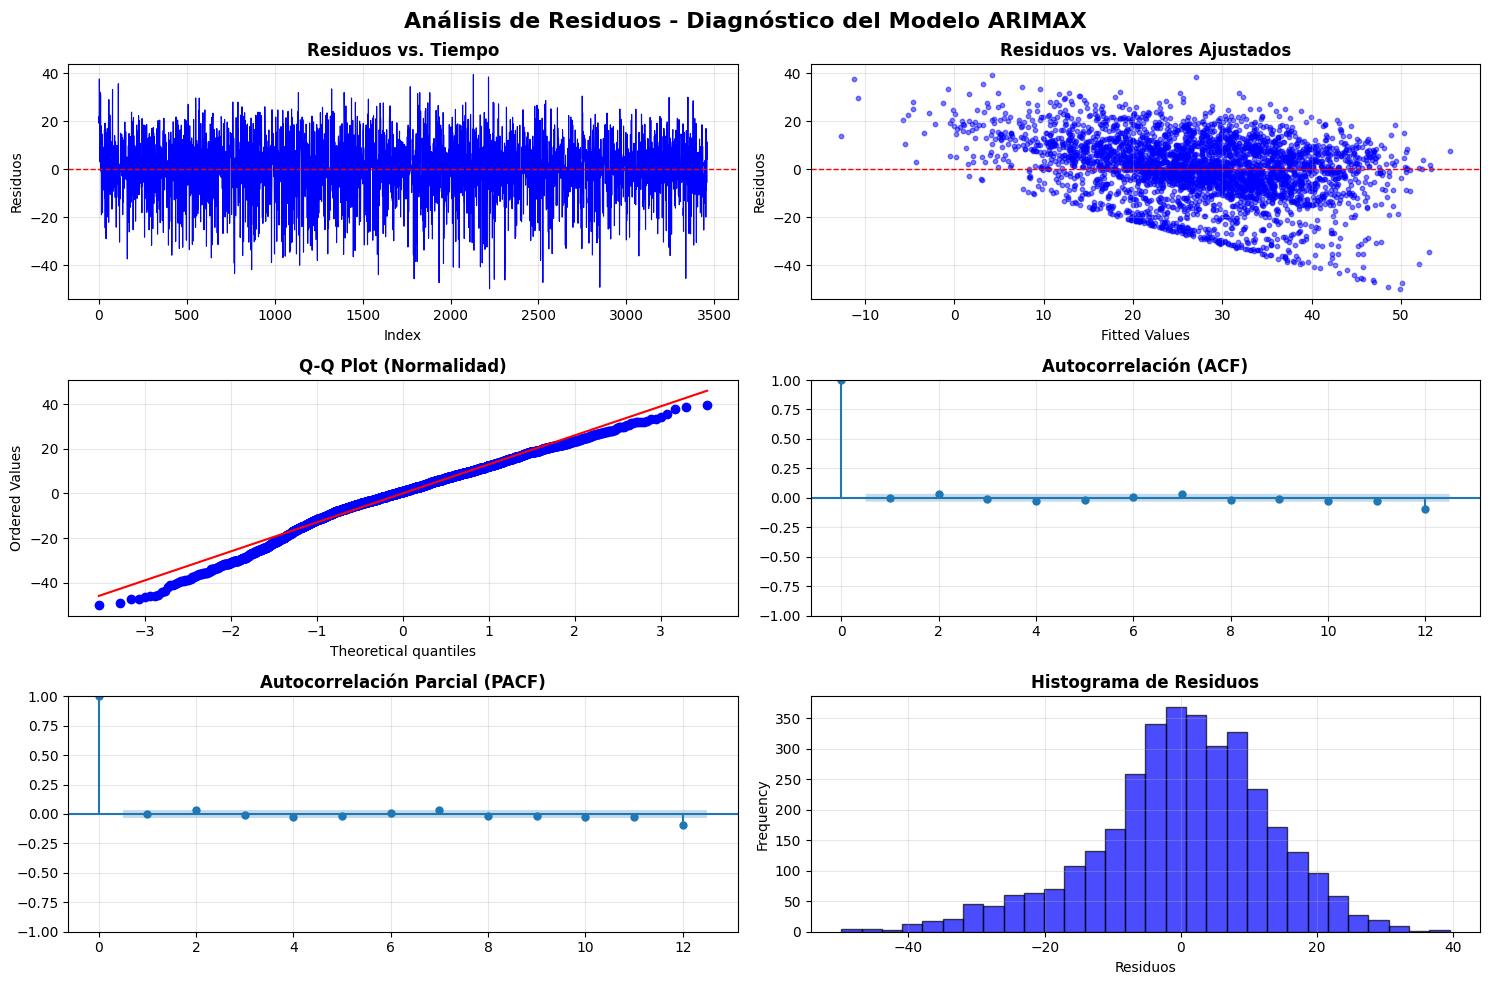

In [21]:

# --- Residuos (en escala Box-Cox) ---
residuals = autoarimax_model.resid()
print("\n----------------- Residuals White Noise Test (Box-Cox) -----------------")
sa.residual_white_noise_test(residuals)
print("-----------------------------------------------------------------------")

# Diagnóstico de residuos (Box-Cox)
residuals_boxcox = autoarimax_model.arima_res_.resid
fitted_values_boxcox = autoarimax_model.arima_res_.fittedvalues
sa.analysis_residuals(residuals_boxcox, fitted_values_boxcox)

In [18]:
autoarimax_model_v2 = auto_arima(
    y=y_train_boxcox,
    X=x_train_exogs,  
    start_p=0,
    d=None,  
    start_q=0,
    max_p=3,  
    max_q=3,
    start_P=0,
    D=None, #TODO: probar a usar D=0
    start_Q=0,
    max_P=2, 
    max_Q=2,
    m=12,
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,  
    n_fits=50,  
    information_criterion='aic', 
)
 
print(autoarimax_model_v2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=29040.872, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=28004.203, Time=98.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=110.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=29038.872, Time=1.19 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=28002.253, Time=2.94 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=28004.588, Time=96.67 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=28006.557, Time=97.61 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=27622.325, Time=6.33 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=27625.658, Time=106.39 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=27625.636, Time=100.90 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=27628.115, Time=119.51 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=27457.428, Time=13.92 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=27459.898, Time=88.19 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=27459.529, Time=82.92 s


----------------- Residuals White Noise Test (Box-Cox) -----------------
[Heteroscedasticity Test] ARCH p-value: 0.019846366956799165 -- range(> 0.05)
[Normality Test] Jarque-Bera p-value: 9.47836085151391e-58 -- range(> 0.05)
[Normality Test] Shapiro-Wilk p-value: 2.6499560805890626e-24 -- range(> 0.05)
[Autocorrelation Test] Ljung-Box p-value:
        lb_stat     lb_pvalue
10  292.318774  6.529001e-57 -- range(> 0.05)
[Autocorrelation Test first order] Durbin-Watson statistic: 2.0842140275868073 -- range(2.0)
-----------------------------------------------------------------------


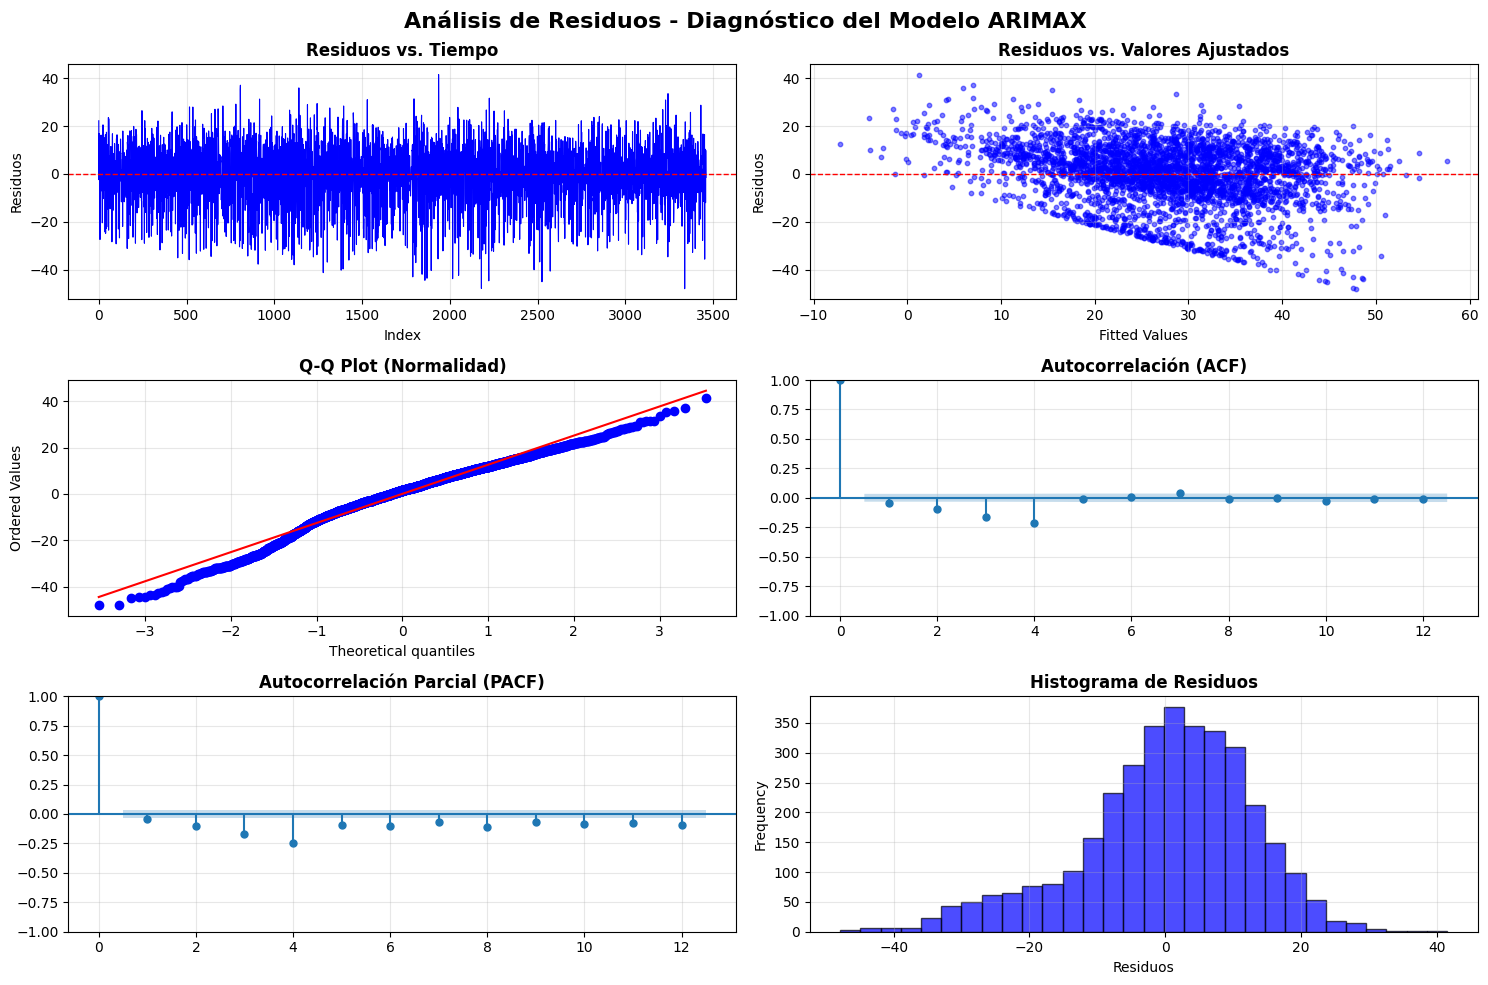

In [19]:
# --- Residuos (en escala Box-Cox) ---
residuals = autoarimax_model_v2.resid()
print("\n----------------- Residuals White Noise Test (Box-Cox) -----------------")
sa.residual_white_noise_test(residuals)
print("-----------------------------------------------------------------------")

# Diagnóstico de residuos (Box-Cox)
residuals_boxcox = autoarimax_model_v2.arima_res_.resid
fitted_values_boxcox = autoarimax_model_v2.arima_res_.fittedvalues
sa.analysis_residuals(residuals_boxcox, fitted_values_boxcox)